In [1]:
# do not use GPR so that we can not complicate things
# instead lets just interpolate the data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
matplotlib.rcParams.update({'font.size': 16})

import numpy as np
import os
import glob
import copy

In [2]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

import rompy as rp

from scrinet.greedy import greedyrb

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# find NR waveforms

In [4]:
import glob
import os

In [5]:
# get data
nrfiles_single_res = dict(
    q1="/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5",
    q2="/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5",
    q4="/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5",
    q5="/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5",
    q10="/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5",
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
)

In [6]:
def make_nr_dict():
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    root_dir = "/Users/spx8sk/work/data/"
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [7]:
nrfiles = make_nr_dict()

In [8]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [9]:
nrfiles_single_res

{'q1': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
 'q2': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
 'q4': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
 'q5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
 'q10': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
 'q18': '/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5'}

In [10]:
nr_q_arr = np.array([float(q.split('q')[-1]) for q in nrfiles_single_res.keys()])

In [11]:
nr_q_arr

array([ 1.,  2.,  4.,  5., 10., 18.])

# generate training data

In [12]:
def gen_model_waveforms(approx, qlist, npts, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_max=t_max) for q in qlist]

In [13]:
def make_training_set(wfs, attr):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    return {'x':x, 'y':y}

In [69]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
q_max = 19
dq = 1

q_arr = np.arange(q_min, q_max, dq)

# time points
npts=1000
t_max=75

# data_to_model = 'amp'
data_to_model = 'phase'
# data_to_model = 'freq'

tol = 1e-16
enriching_tol = 1e-16


# wf models to enrich the basis
enriching_approxs = copy.copy(approxs)
enriching_approxs.remove(start_approx)

In [70]:
start_approx

'SEOBNRv4_opt'

In [71]:
approxs

['SEOBNRv4_opt']

In [17]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_max=t_max, nrfiles=nrfiles_single_res)})

In [18]:
model_wfs.keys()

dict_keys(['SEOBNRv4_opt'])

In [72]:
# model_grb_ts: the greedy reduced basis training set for each model
model_grb_ts = {}
for approx in approxs:
    model_grb_ts.update({approx:make_training_set(model_wfs[approx], data_to_model)})

In [73]:
common_times = model_wfs[start_approx][0].times
integration = rp.Integration([common_times[0], common_times[-1]], len(common_times), rule="trapezoidal") 

# build bases

## initial basis

In [74]:
def build_basis(ts, times=common_times, tol=1e-8, seed_index=0):
    integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal") 
    grb = greedyrb.NewGreedyReducedBasis(integration)
    grb.make(ts=ts, tol=tol, seed_index=seed_index, rel=False)
    return grb

In [75]:
# keep track of the waveforms that were selected by the greedy method
grb_indicies = {}

print(f"building intial reduced basis for model: {start_approx}")
grb = build_basis(model_grb_ts[start_approx]['y'], times=common_times, tol=tol)
grb_indicies.update({start_approx:grb.indices})

building intial reduced basis for model: SEOBNRv4_opt

Step 	 Error
1 	 17743316.736751392
2 	 63095.27881000191
3 	 112.87827690504491
4 	 3.7272874377667904
5 	 0.009610159322619438
6 	 0.0008463915437459946
7 	 0.00026995129883289337
8 	 1.9688159227371216e-06
9 	 6.575137376785278e-07
10 	 5.587935447692871e-07
11 	 2.905726432800293e-07
12 	 2.2724270820617676e-07
13 	 1.7881393432617188e-07
14 	 1.2479722499847412e-07
15 	 7.078051567077637e-08
16 	 5.029141902923584e-08
17 	 1.862645149230957e-08
18 	 9.313225746154785e-09


In [76]:
grb_indicies

{'SEOBNRv4_opt': array([ 0, 17,  5,  2, 11,  3,  1,  7,  4, 10, 13, 14,  6,  9, 15,  8, 16,
        12], dtype=int32)}

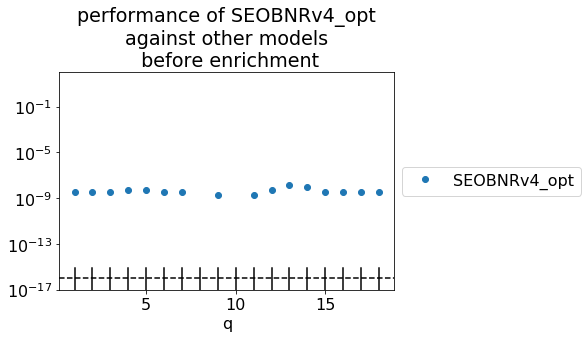

In [77]:
x_greedy_points = model_grb_ts[start_approx]['x'][grb_indicies[start_approx]]

plt.figure()

for approx in approxs:
    x = model_grb_ts[approx]['x']
    y = model_grb_ts[approx]['y']
    plt.plot(x, np.abs(grb.validate(y)), 'o', label=f"{approx}")

plt.yscale('log')
plt.ylim(1e-17, 1e2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'performance of {start_approx}\nagainst other models\n before enrichment');
plt.axhline(tol, ls='--', c='k')
plt.xlabel('q')

for x in x_greedy_points:
    plt.axvline(x, ymax=0.1, c='k')

## enrich basis

In [78]:
for approx in enriching_approxs:
    print("="*30)
    print(f"enriching with {approx}")
    print("="*30)
    grb.enrich(model_grb_ts[approx]['y'], tol=enriching_tol)

    grb_indicies.update({approx:grb.indices})
    print("")

In [79]:
grb_indicies

{'SEOBNRv4_opt': array([ 0, 17,  5,  2, 11,  3,  1,  7,  4, 10, 13, 14,  6,  9, 15,  8, 16,
        12], dtype=int32)}

In [80]:
model_grb_ts[approxs[1]]['x'][grb_indicies[approxs[1]]]

IndexError: list index out of range

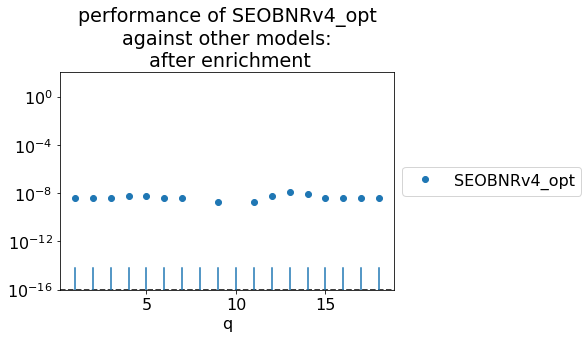

In [81]:
plt.figure()

for approx in approxs:
    x = model_grb_ts[approx]['x']
    y = model_grb_ts[approx]['y']
    plt.plot(x, np.abs(grb.validate(y)), 'o', label=f"{approx}")
    
plt.yscale('log')
plt.ylim(1e-16, 1e2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'performance of {start_approx}\nagainst other models:\n after enrichment');
plt.axhline(tol, ls='--', c='k')
plt.xlabel('q')

for approx in approxs:
    x_greedy_points = model_grb_ts[approx]['x'][grb_indicies[approx]]

    for x in x_greedy_points:
        plt.axvline(x, ymax=0.1)

In [82]:
print(f"size of basis after enrichment: {grb.size}")

size of basis after enrichment: 18


## build final basis from the greedy points at each step

In [83]:
x_greedy_points = {}
y_greedy_points = {}
for approx in approxs:
    x_greedy_points.update({approx:model_grb_ts[approx]['x'][grb_indicies[approx]]})
    y_greedy_points.update({approx:model_grb_ts[approx]['y'][grb_indicies[approx]]})

In [84]:
# remake final basis using all greedy points
# so that we can get rid of redundent greedy points
final_ts_x = np.concatenate([v for v in x_greedy_points.values()])
final_ts_y = np.row_stack([v for v in y_greedy_points.values()])

In [85]:
final_ts_x.shape

(18,)

In [86]:
final_ts_y.shape

(18, 1000)

In [87]:
final_grb = build_basis(final_ts_y, times=common_times, tol=tol)


Step 	 Error
1 	 17743316.736751392
2 	 63095.27881000191
3 	 112.87827690504491
4 	 3.7272874377667904
5 	 0.009610159322619438
6 	 0.0008463915437459946
7 	 0.00026995129883289337
8 	 1.9688159227371216e-06
9 	 6.575137376785278e-07
10 	 5.587935447692871e-07
11 	 2.905726432800293e-07
12 	 2.2724270820617676e-07
13 	 1.7881393432617188e-07
14 	 1.2479722499847412e-07
15 	 7.078051567077637e-08
16 	 5.029141902923584e-08
17 	 1.862645149230957e-08
18 	 9.313225746154785e-09


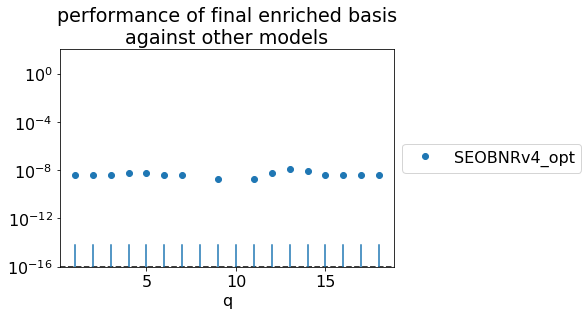

In [88]:
plt.figure()

for approx in approxs:
    x = model_grb_ts[approx]['x']
    y = model_grb_ts[approx]['y']
    plt.plot(x, np.abs(final_grb.validate(y)), 'o', label=f"{approx}")


plt.yscale('log')
plt.ylim(1e-16, 1e2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'performance of final enriched basis\nagainst other models');
plt.axhline(tol, ls='--', c='k')
plt.xlabel('q')

x_greedy_points = final_ts_x[final_grb.indices]

for x in x_greedy_points:
    plt.axvline(x, ymax=0.1)

In [89]:
print(x_greedy_points)

[ 1 18  6  3 12  4  2  8  5 11 14 15  7 10 16  9 17 13]


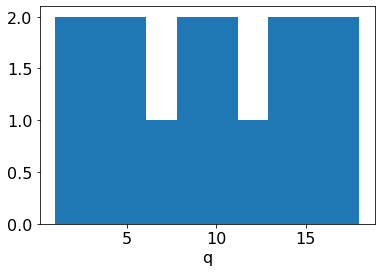

In [90]:
plt.figure()
plt.hist(x_greedy_points)
plt.xlabel('q');

## build EIM

In [91]:
eim = rp.EmpiricalInterpolant(final_grb.basis, verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 999)
(2, '\t', 881)
(3, '\t', 967)
(4, '\t', 551)
(5, '\t', 936)
(6, '\t', 957)
(7, '\t', 976)
(8, '\t', 950)
(9, '\t', 962)
(10, '\t', 875)
(11, '\t', 868)
(12, '\t', 961)
(13, '\t', 960)
(14, '\t', 959)
(15, '\t', 854)
(16, '\t', 886)
(17, '\t', 953)
(18, '\t', 838)


In [92]:
np.transpose(model_grb_ts[approx]['y'])

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.75003656e-02, -9.04070159e-02, -9.47524319e-02, ...,
        -1.30001613e-01, -1.31686496e-01, -1.33293306e-01],
       [-1.75032194e-01, -1.80846059e-01, -1.89537759e-01, ...,
        -2.60040619e-01, -2.63410498e-01, -2.66624199e-01],
       ...,
       [-1.66938516e+02, -1.68443088e+02, -1.70739896e+02, ...,
        -1.95942745e+02, -1.97291154e+02, -1.98578910e+02],
       [-1.68087929e+02, -1.69528977e+02, -1.71758278e+02, ...,
        -1.96774824e+02, -1.98120088e+02, -1.99405035e+02],
       [-1.69237343e+02, -1.70614867e+02, -1.72776660e+02, ...,
        -1.97606905e+02, -1.98949022e+02, -2.00231161e+02]])

In [93]:
model_eim_coeff = {}
for approx in approxs:
    model_eim_coeff.update({approx:np.transpose(model_grb_ts[approx]['y'])[eim.indices]})

In [94]:
model_eim_coeff['NR'].shape

KeyError: 'NR'

In [95]:
# for i in range(eim.size):
#     plt.figure()
#     for approx in approxs:
#         plt.plot(model_grb_ts[approx]['x'], model_eim_coeff[approx][i], 'o-', label=approx)
#     plt.title(f"EIM coeff: {i}")
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()
#     plt.close()

# multifidelity modelling

In [96]:
# here we construct a model for each coefficient as a function of mass-ratio for each model.
# here we will just use splines and interpolate.

# we will then, for each coefficient, compute the mean value across the different models
# then we will compute the difference between all models and the mean value.

# then we save the mean, and the difference to file.

# then when we want to use the model we sample from a uniform distribution of mean +/- difference.

In [97]:
def interpolate_list(x, ys):
    """
    x : array of mass-ratios
    ys: list of arrays for each eim coefficient
    """
    iy=[]
    for y in ys:
        iy.append(IUS(x, y))
    return iy

In [98]:
ieim = {}
for approx in approxs:
    x = model_grb_ts[approx]['x']
    ys = model_eim_coeff[approx]
    ieim.update({approx:interpolate_list(x, ys)})

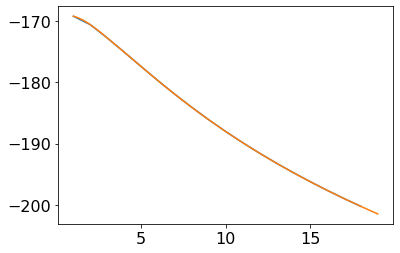

In [99]:
plt.figure()
plt.plot(model_grb_ts[start_approx]['x'], model_eim_coeff[start_approx][0])
xx = np.linspace(1,19,100)
plt.plot(xx, ieim[start_approx][0](xx))

In [100]:
def compute_average(x_dense, iys):
    results = {}
    for approx in iys.keys():
        ys = []
        size = len(iys[approx]) # number of coefficients, should be a constant for all
        for i in range(size):
            ys.append(iys[approx][i](x_dense))
        results.update({approx:np.asarray(ys)})
            
    return results
    

In [101]:
def compute_average(x_dense, iys):
    results = []
    for approx in iys.keys():
        ys = []
        size = len(iys[approx]) # number of coefficients, should be a constant for all
        for i in range(size):
            ys.append(iys[approx][i](x_dense))
        results.append(ys)
            
    return np.asarray(results)
    

In [102]:
x_dense = np.linspace(q_min, q_max, 20)
y_dense = compute_average(x_dense, ieim)

In [103]:
y_dense.shape
# first is approximant
# second is eim
# third is samples from function

(1, 18, 20)

In [104]:
np.mean(y_dense, axis=0).shape

(18, 20)

In [105]:
y_mean = np.mean(y_dense, axis=0)
y_min = np.min(y_dense, axis=0)
y_max = np.max(y_dense, axis=0)

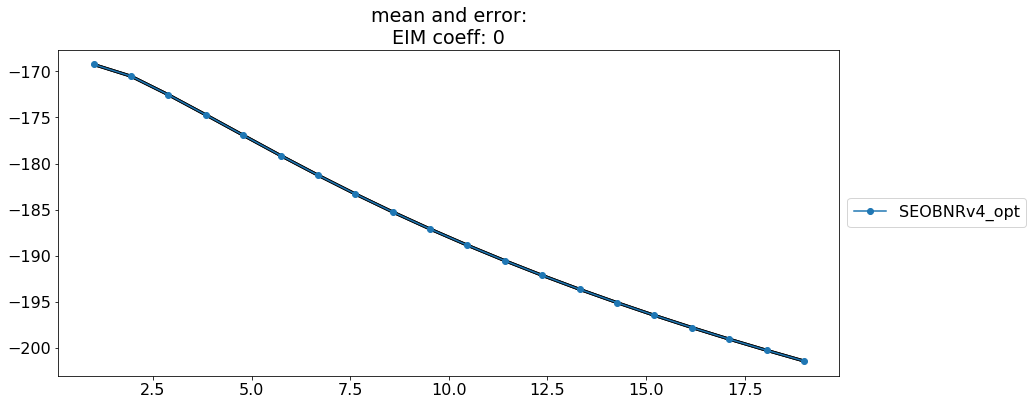

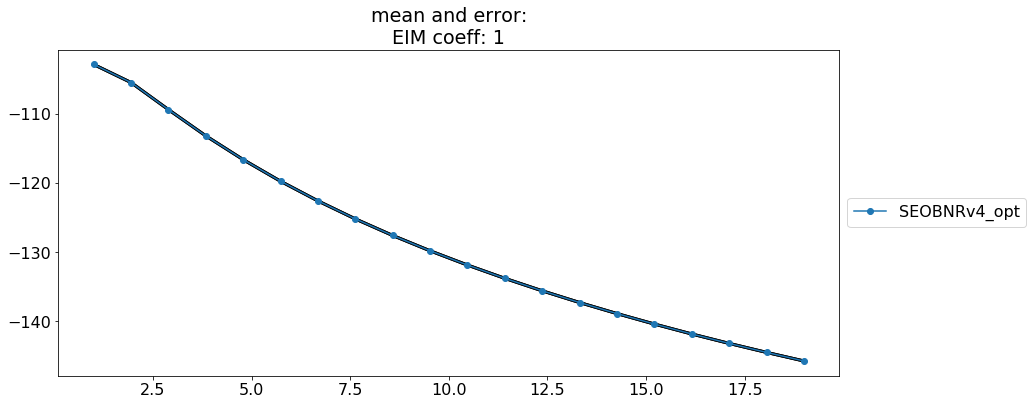

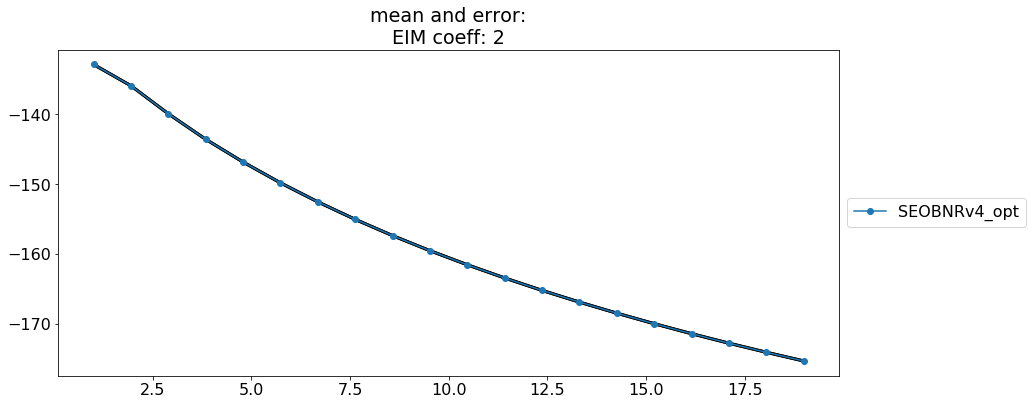

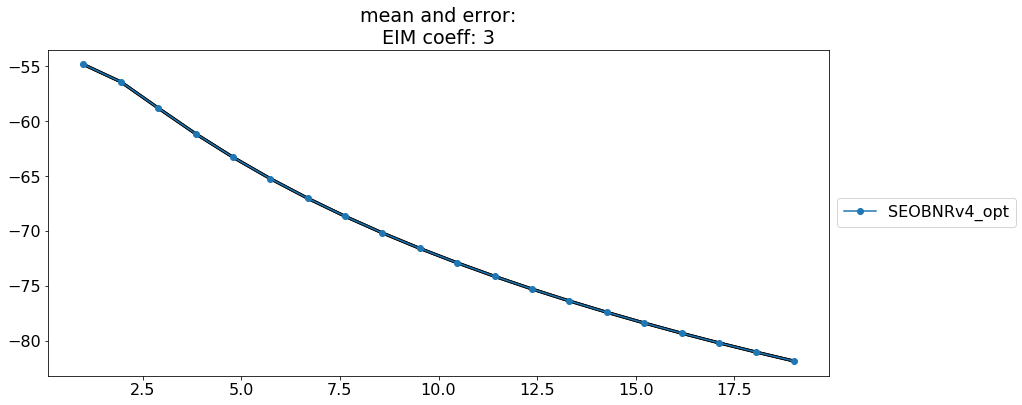

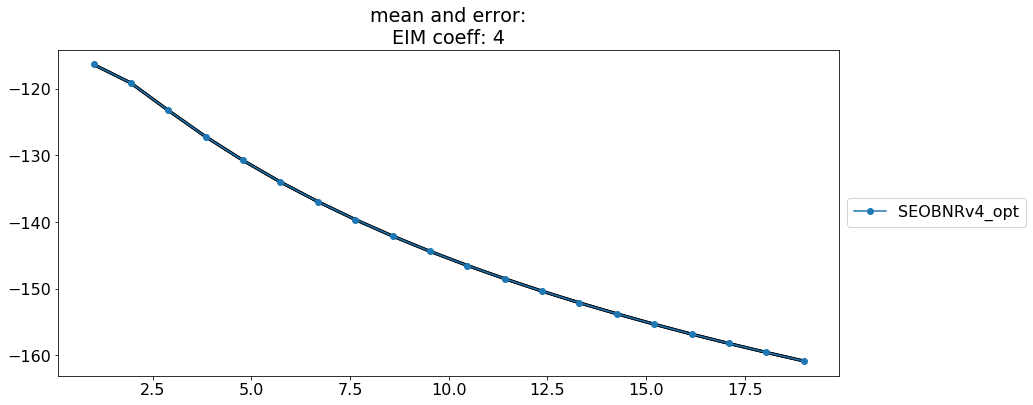

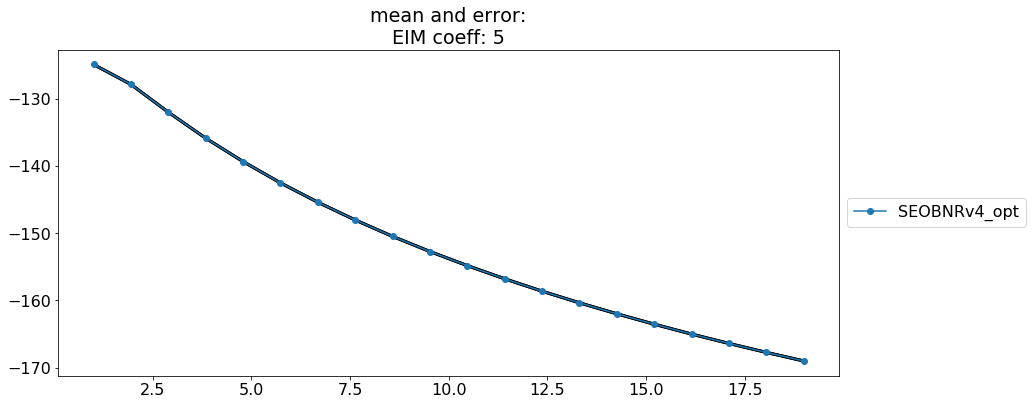

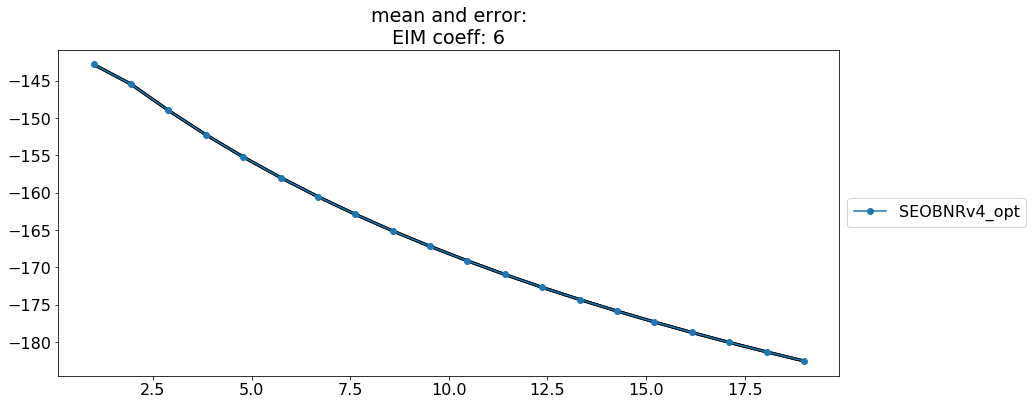

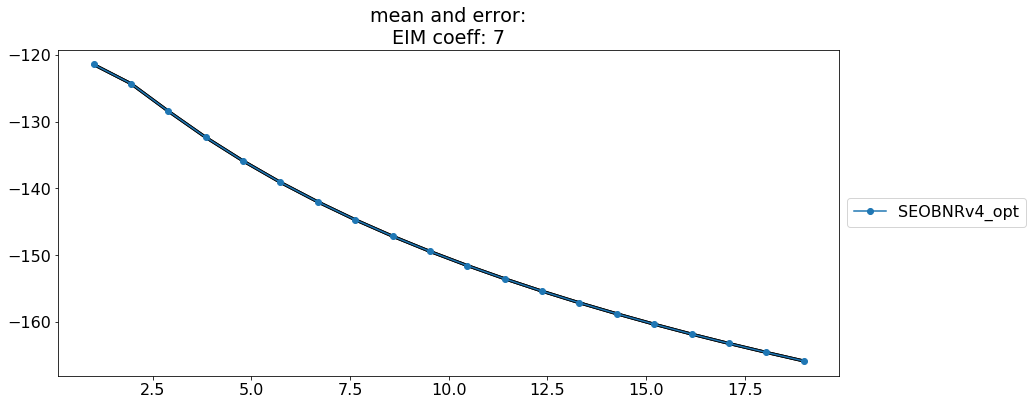

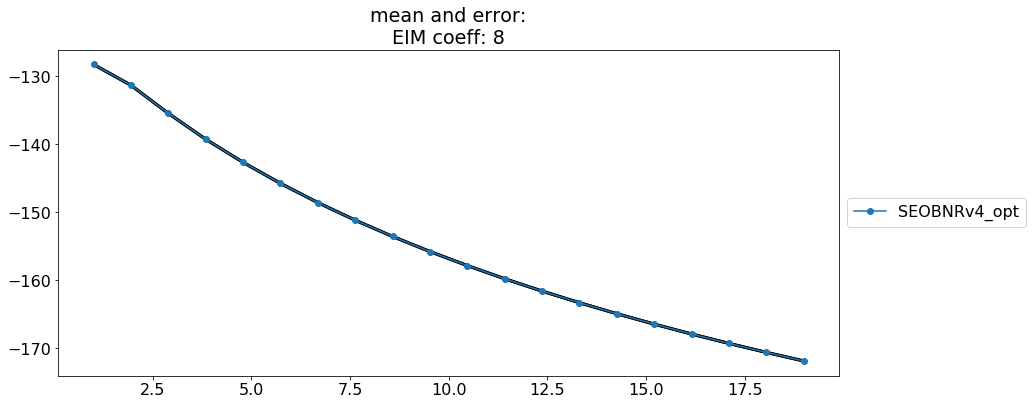

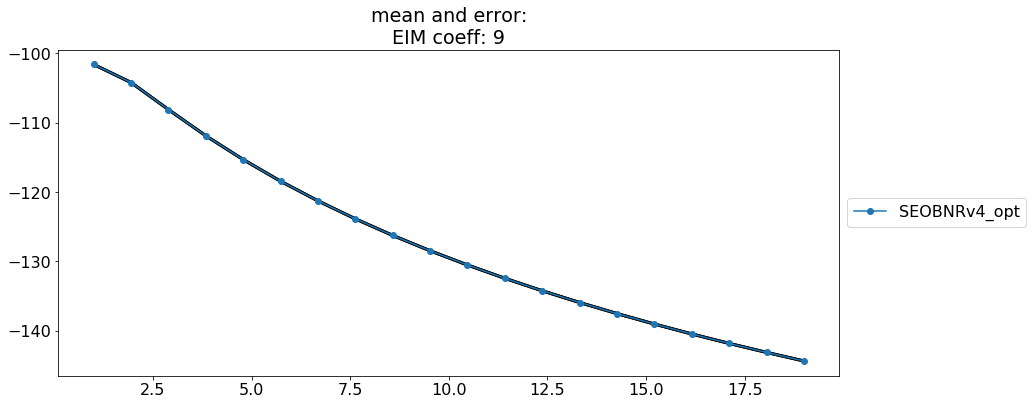

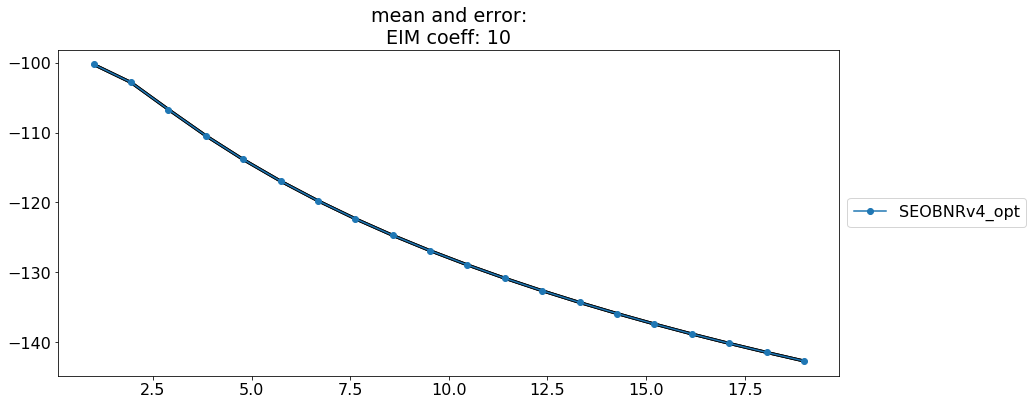

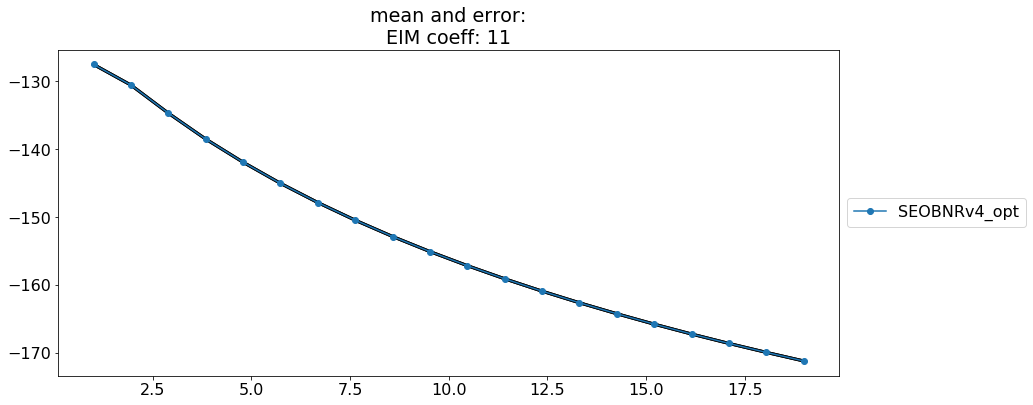

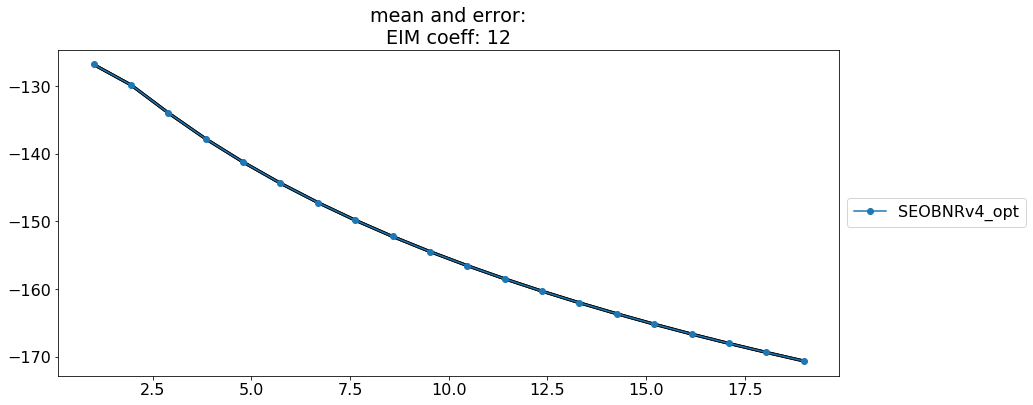

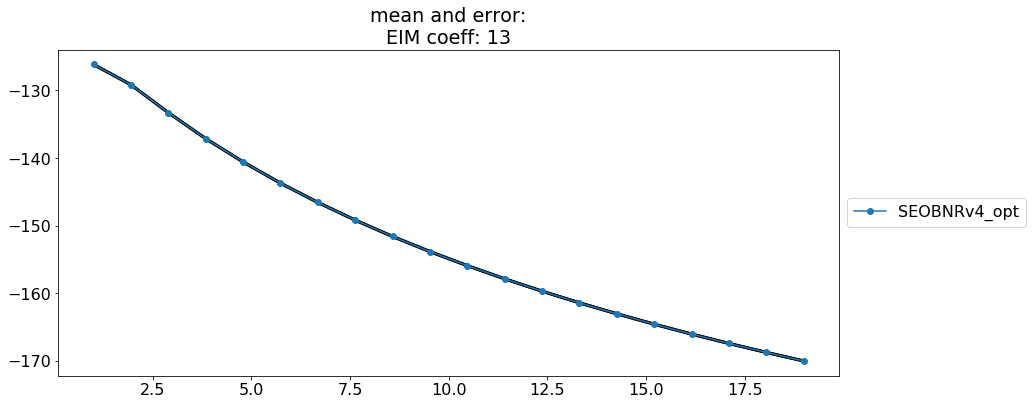

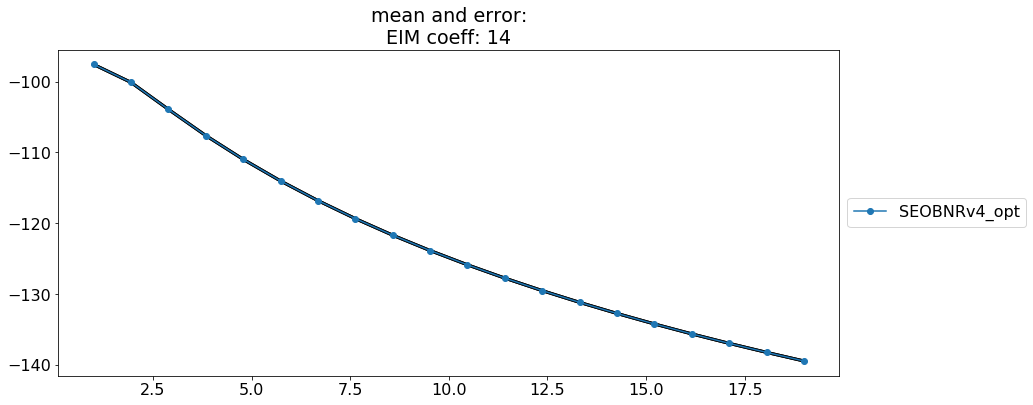

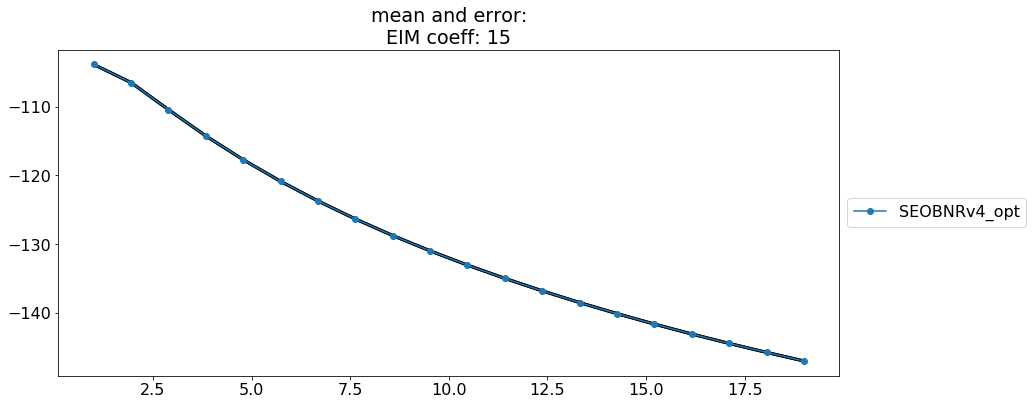

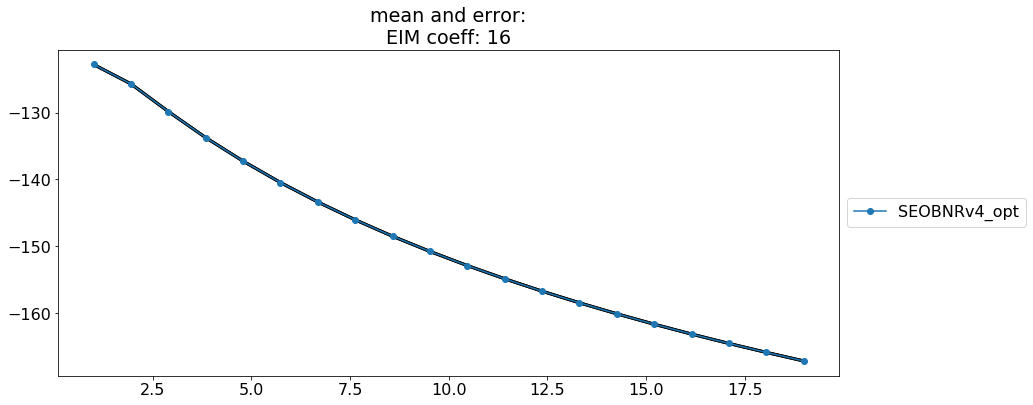

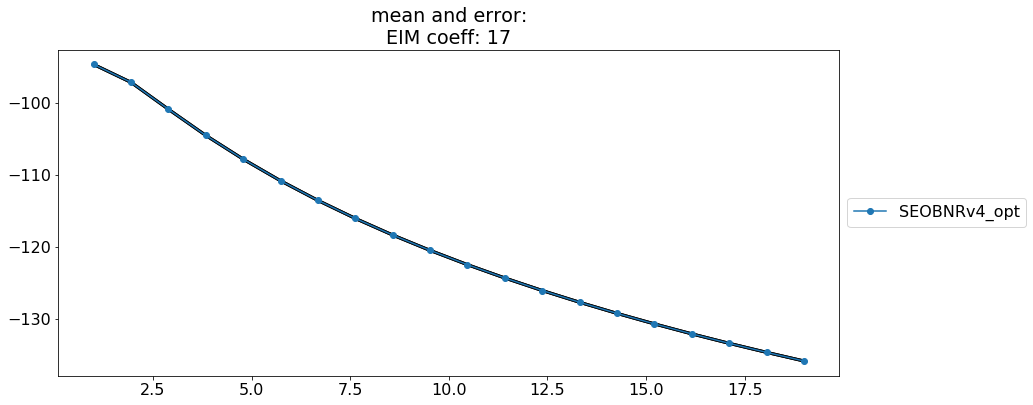

In [106]:
for i in range(eim.size):
# for i in range(2):

    plt.figure(figsize=(14, 6))
    
    plt.plot(x_dense, y_mean[i], c='k', lw=3, alpha=0.8)
    plt.plot(x_dense, y_min[i], c='k', lw=3, alpha=0.8)
    plt.plot(x_dense, y_max[i], c='k', lw=3, alpha=0.8)
    
    plt.fill_between(x_dense, y1=y_min[i], y2=y_max[i], alpha=0.5)

    for j in range(y_dense.shape[0]):
        plt.plot(x_dense, y_dense[j][i], 'o-', label=approxs[j])


    plt.title(f"mean and error:\nEIM coeff: {i}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

In [107]:
iy_means = interpolate_list(x_dense, y_mean)
iy_mins = interpolate_list(x_dense, y_min)
iy_maxs = interpolate_list(x_dense, y_max)

In [108]:
def get_random_coeff(q, iy_mins, iy_maxs):
    num = len(iy_mins)
    
    ymins = [iy_min(q) for iy_min in iy_mins]
    ymaxs = [iy_max(q) for iy_max in iy_maxs]
    
    alphas = [np.random.uniform(ymins[i], ymaxs[i]) for i in range(num)]
    
    return np.asarray(alphas)

In [109]:
def get_mean_coeff(q, iy_means):
    num = len(iy_means)
    ymeans = [iy_mean(q) for iy_mean in iy_means]
    
    return np.asarray(ymeans)

In [110]:
def predict(alpha, B=eim.B):
    return np.dot(alpha, B)

In [111]:
# generate models at NR locations
NR_locations_model_wfs = {}
qs = model_grb_ts["NR"]['x']
for approx in approxs:
    NR_locations_model_wfs.update({approx:gen_model_waveforms(approx, qs, npts, t_max=t_max, nrfiles=nrfiles_single_res)})
    
NR_locations_model_grb_ts = {}
for approx in approxs:
    NR_locations_model_grb_ts.update({approx:make_training_set(NR_locations_model_wfs[approx], data_to_model)})

KeyError: 'NR'

In [ ]:
NR_locations_model_grb_ts[approx]['y'].shape

In [ ]:
NR_locations_model_grb_ts["NR"]['x'].shape

In [ ]:
def compare_with_models_at_NR_locations():
    qs = NR_locations_model_grb_ts["NR"]['x']
    for i, q in enumerate(qs):
        num_draws = 100
        y_draws = []
        for j in range(num_draws):
            y_draws.append(predict(get_random_coeff(q, iy_mins, iy_maxs)))
            
        y_draws = np.asarray(y_draws)
        y_draws_min = np.min(y_draws, axis=0)
        y_draws_max = np.max(y_draws, axis=0)
        
        plt.figure(figsize=(14, 6))
        
        plt.fill_between(common_times, y1=y_draws_min, y2=y_draws_max, color='C0', alpha=0.2)
        
        for y_draw in y_draws:
            plt.plot(common_times, y_draw, c='C0', alpha=0.02)
            
        plt.plot(common_times, predict(get_mean_coeff(q, iy_means)), label='mean')
        
        plt.plot(common_times[eim.indices], predict(get_mean_coeff(q, iy_means))[eim.indices], 'o')
        
        
        for approx in approxs:
            y = NR_locations_model_grb_ts[approx]['y'][i]
            plt.plot(common_times, y, label=approx)
        plt.title(f"compare with models at NR locations: q = {q}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
#         plt.yscale('log')
        plt.xlim(-100, 100)
#         plt.xlim(-500, 100)
#         plt.xlim(0, 100)
#         plt.ylim(-200, -100)
#         plt.ylim(-0.6, 0)
        plt.show()
        plt.close()

In [112]:
compare_with_models_at_NR_locations()

NameError: name 'NR_locations_model_grb_ts' is not defined

In [113]:
# q = nr_q_arr[0]
q = 2
print(f"predicting: q = {q}")
num_draws = 100
y_draws = []
for i in range(num_draws):
    y_draws.append(predict(get_random_coeff(q, iy_mins, iy_maxs)))

predicting: q = 2


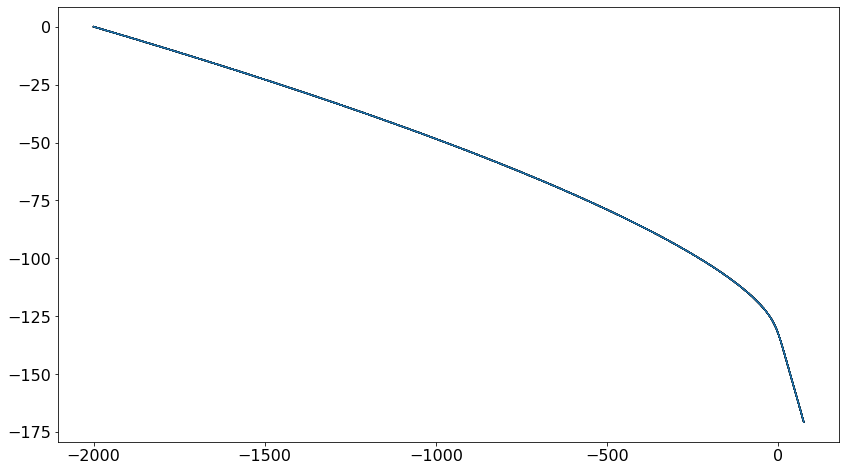

In [114]:
plt.figure(figsize=(14, 8))
for y_draw in y_draws:
    plt.plot(common_times, y_draw, c='k', alpha=0.05)
    
plt.plot(common_times, predict(get_mean_coeff(q, iy_means)))

# plt.xlim(-100, 100)

# saving the model

In [115]:
import tempfile
import datetime

In [116]:
def make_tag(prefix):
    """
    use temp file and datetime to get a unique name that begins
    with 'prefix', has a middle that is the data and ends
    with a random string.

    by default prefix is 'exp' that is short for experiment.

    name template: '[prefix]_[%y%m%d]_[random]'
    """
    date_now = datetime.datetime.now().strftime("%y%m%d")
    with tempfile.NamedTemporaryFile(prefix=f"{prefix}_{date_now}_") as temp:
        tag = temp.name.split("/")[-1]
    return tag

In [117]:
save = True

In [118]:
if save:
    model_name = make_tag(data_to_model)

    print(f"making output directory: {model_name}")
    os.makedirs(f"{model_name}")

    # save eim
    # basis
    np.save(os.path.join(model_name, "eim_basis.npy"), eim.B)
    # eim indicies
    np.save(os.path.join(model_name, "eim_indices.npy"), eim.indices)

    # save mean, min and max

    np.save(os.path.join(model_name, "x.npy"), x_dense)
    np.save(os.path.join(model_name, "ymean.npy"), y_mean)
    np.save(os.path.join(model_name, "ymin.npy"), y_min)
    np.save(os.path.join(model_name, "ymax.npy"), y_max)
    
    np.save(os.path.join(model_name, "times.npy"), common_times)

making output directory: phase_210218_7fhho7jv
